In [68]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 250, 1
epsilon = 5000

height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
params0= journal0.get_parameters()
print("Posterior mean", journal0.posterior_mean())
print("Covariance matrix:")
print(journal0.posterior_cov())
#print(2*np.sqrt(journal.posterior_cov()[0][1][1]))

distance_data = []
hell_data = []

distance_summary = []
hell_summary = []

distance_mean_mu = []
distance_mean_sigma = []

hell_mu = []
hell_sigma = []

monte_mu = []
monte_sigma = []



for i in range(50):
    # New observed data 
    height_obs = height.forward_simulate([170, 10], k=50)
    
    distance_data.append(np.linalg.norm(np.array(height_obs) - np.array(height_obs0)))
    distance_summary.append(distance_calculator.distance(height_obs, height_obs0))
    hell_data.append(hell(height_obs, height_obs0))
    
    journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)
    #print("Posterior mean", journal.posterior_mean())
    #print("Covariance matrix:")
    #print(journal.posterior_cov())
    #print(2*np.sqrt(journal.posterior_cov()[0][1][1]))
    
    distance_mean_mu.append(np.linalg.norm(journal.posterior_mean()['mu'] - journal0.posterior_mean()['mu']))
    distance_mean_sigma.append(np.linalg.norm(journal.posterior_mean()['sigma'] - journal0.posterior_mean()['sigma']))
    
    params = journal.get_parameters()
    
    hell_mu.append(hell_Gaussian(params0['mu'], params['mu'], 0.3, n=1000, plot = False))
    hell_sigma.append(hell_Gaussian(params0['sigma'], params['sigma'], 0.3, n=1000, plot = False))
    
    monte_mu.append(monte_carlo(params0['mu'], params['mu']))
    monte_sigma.append(monte_carlo(params0['sigma'], params['sigma']))

Posterior mean {'mu': 173.04931533976062, 'sigma': 13.62721130853107}
Covariance matrix:
(array([[127.03460442,   2.79819562],
       [  2.79819562,  32.38898338]]), dict_keys(['mu', 'sigma']))


In [67]:
import matplotlib.pyplot as plt
def hell(y0, y1, step = 0.2):
    ''' Compute discrete hell distance for two data sets.
    :params y0, y1: data
            step: width of bins for the histgram
    '''
    # Interval for the histogram
    a = min(np.amin(y0), np.amin(y1))
    b = max(np.amax(y0), np.amax(y1))
    
    # generate histgrams for the two data sets
    hist0 = np.histogram(y0, bins = np.arange(a, b, step), density = True)
    hist1 = np.histogram(y1, bins = np.arange(a, b, step), density = True)
    
    return hellinger(hist0[0]/100, hist1[0]/100)

def hellinger(p, q):
    """Hellinger distance between distributions"""
    return np.sqrt(sum([(np.sqrt(t[0])-np.sqrt(t[1]))**2
                for t in zip(p,q)])) / np.sqrt(2.)

from scipy.stats import gaussian_kde


def Gaussian_kde(X, bandwidth, eval_points, plot = False):
    
    #positions = np.linspace(xmin, xmax, 100)
    kernel = gaussian_kde(X, bw_method=bandwidth)
    y_sp = kernel.pdf(eval_points)
    
    if plot:
        plt.plot(eval_points, y_sp)
    
    return y_sp

def hell_Gaussian(y0, y1, bandwidth, n, plot = False, squeeze = True):
    ''' Compute Hellinger distance for two accepted parameter sets.
    :params y0, y1: data
            step: width of bins for the histgram
    '''
    if squeeze:
        y0 = np.array(np.squeeze(y0))
        y1 = np.array(np.squeeze(y1))
        
    # Interval for the histogram
    a = min(np.amin(y0), np.amin(y1))
    b = max(np.amax(y0), np.amax(y1))
    
    eval_points = np.linspace(a, b, n)
    
    # Evaluate pdf of Gaussian kde
    p0 = Gaussian_kde(y0, bandwidth, eval_points, plot)
    p1 = Gaussian_kde(y1, bandwidth, eval_points, plot)
    
    # Normalise the result
    #p0 = p0/trapezoidal(eval_points, p0)
    #p1 = p0/trapezoidal(eval_points, p1)
    
    #print(p0)
    
 
    # Evaluate continuous hell distance
    step = (b-a)/(n-1)
    d = continuous_hellinger(p0, p1, step) - 1 + 0.5 * (trapezoidal(eval_points, p0) + trapezoidal(eval_points, p1))
    return d
\
def continuous_hellinger(f,g, step):
    """
    Given equally spaced values of pdf f,g, calculate Hellinger distance using Trapezoidal rule.
    """
    #print(f-g)
    sq_fg = np.sqrt(f*g)
    return 1 - step*sum(sq_fg[1:-1])-step*(1/2)*(sq_fg[0]+sq_fg[-1])

def trapezoidal(x,y):
    n = len(x)
    integral = (np.dot( (x[1:]-x[:-1]) , (y[1:]+y[:-1]) ))/2
    return integral

def monte_carlo(y0, y1, h, squeeze = True):
    if squeeze:
        y0 = np.array(np.squeeze(y0))
        y1 = np.array(np.squeeze(y1))
    n = y0.shape[0]
    return np.abs(1/n * (np.sum(1/y0) - np.sum(1/y1)))

def h(x, c):
    return np.exp(-(x-c)**2) 


In [61]:

np.sum(1/np.array(np.squeeze(params['mu'])))


2.8557541842258427

7.771561172376096e-16


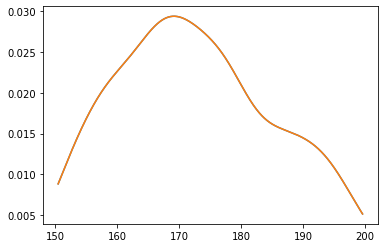

In [8]:
y_sp = hell_Gaussian(params['mu'], params['mu'], 0.3, n=1000, plot = True)
print(y_sp)


"'\nplt.show()\n\nfig0 = plt.figure()\n#plt.plot(distance_data, distance_mean_mu, 'bo')\n#plt.plot(distance_data, distance_mean_sigma, 'go')\n\nplt.plot(hell_data, np.array(hell_mu)/np.array(hell_data), 'bx', label=r'$\\mu$')\nplt.plot(hell_data, np.array(hell_sigma)/np.array(hell_data), 'gx', label=r'$\\sigma$')\n#print(hell_mu)\n#print(hell_sigma)\nplt.xlabel('Hellinger distance between observed data')\nplt.ylabel('Hellinger distance between pos')\n#plt.title('Histogram of IQ')\n\nplt.legend()\nplt.savefig('hell2')\n\nplt.show()\n\nfig0 = plt.figure()\n#plt.plot(distance_data, distance_mean_mu, 'bo')\n#plt.plot(distance_data, distance_mean_sigma, 'go')\n\nplt.plot(distance_data, hell_mu, 'bx', label=r'$\\mu$')\nplt.plot(distance_data, hell_sigma, 'gx', label=r'$\\sigma$')\n#print(hell_mu)\n#print(hell_sigma)\nplt.xlabel('Euclidean distance between observed data')\nplt.ylabel('Hellinger distance between pos')\n#plt.title('Histogram of IQ')\n\nplt.legend()\nplt.savefig('hell2')\n\nplt.

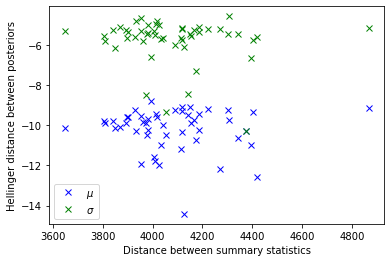

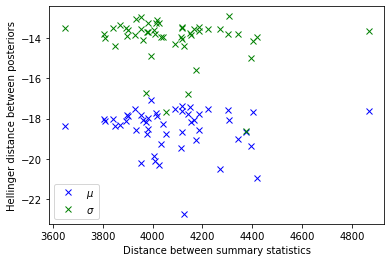

In [72]:
'''
fig0 = plt.figure()
plt.plot(distance_data, distance_mean_mu, 'bo')
plt.plot(distance_data, distance_mean_sigma, 'go')

fig1 = plt.figure()
plt.plot(hell_data, hell_mu, 'bx', label=r'$\mu$')
plt.plot(hell_data, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Distance between observed data')
plt.ylabel('Hellinger distance between posteriors')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell1')

fig1 = plt.figure()
plt.plot(distance_summary, np.array(hell_mu), 'bx', label=r'$\mu$')
plt.plot(distance_summary, np.array(hell_sigma), 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Distance between summary statistics')
plt.ylabel('Hellinger distance between posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell2')


fig2 = plt.figure()
plt.plot(distance_summary, (np.array(hell_mu)) / distance_summary, 'bx', label=r'$\mu$')
plt.plot(distance_summary, (np.array(hell_sigma) ) / distance_summary, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Distance between summary statistics')
plt.ylabel('Hellinger distance between posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell3')
'''

fig1 = plt.figure()
plt.plot(distance_summary, np.log(np.array(monte_mu)), 'bx', label=r'$\mu$')
plt.plot(distance_summary, np.log(np.array(monte_sigma)), 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Distance between summary statistics')
plt.ylabel('Hellinger distance between posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell2')


fig1 = plt.figure()
plt.plot(distance_summary, np.log(np.array(monte_mu)/ distance_summary), 'bx', label=r'$\mu$')
plt.plot(distance_summary, np.log(np.array(monte_sigma)/ distance_summary), 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Distance between summary statistics')
plt.ylabel('Hellinger distance between posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell2')


''''
plt.show()

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(hell_data, np.array(hell_mu)/np.array(hell_data), 'bx', label=r'$\mu$')
plt.plot(hell_data, np.array(hell_sigma)/np.array(hell_data), 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Hellinger distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_data, hell_mu, 'bx', label=r'$\mu$')
plt.plot(distance_data, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Euclidean distance between observed data')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()

fig0 = plt.figure()
#plt.plot(distance_data, distance_mean_mu, 'bo')
#plt.plot(distance_data, distance_mean_sigma, 'go')

plt.plot(distance_summary, hell_mu, 'bx', label=r'$\mu$')
plt.plot(distance_summary, hell_sigma, 'gx', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Euclidean distance between summary statistics')
plt.ylabel('Hellinger distance between pos')
#plt.title('Histogram of IQ')

plt.legend()
plt.savefig('hell2')

plt.show()
'''

## Convergence

In [50]:
from abcpy.continuousmodels import Uniform, Normal as Gaussian
from abcpy.statistics import Identity, LinearTransformation
import numpy as np
from abcpy.distances import Euclidean
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import RejectionABC

# define priors
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

# Try 100 times

n_sample, n_samples_per_param = 10, 15
epsilon = 5000


distance_data = []
hell_data = []

distance_summary = []
hell_summary = []

distance_mean_mu = []
distance_mean_sigma = []

hell_mu = []
hell_sigma = []


height_obs0 = height.forward_simulate([170, 10], k=50)
journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
params0= journal0.get_parameters()
param = [params0]
accepted_mean = []
posterior_mean = [journal.posterior_mean()]


for n_sample in range(20, 700, 10):
    
    journal0 = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
    params0 = journal0.get_parameters()
    
    param.append(params0)
    
    hell_mu.append(hell_Gaussian(param[-1]['mu'], param[-2]['mu'], 0.3, n=1000, plot = False))
    hell_sigma.append(hell_Gaussian(param[-1]['sigma'], param[-2]['sigma'], 0.3, n=1000, plot = False))
    
    posterior_mean.append(journal0.posterior_mean())
    
    #distance_mean_mu.append(np.linalg.norm(posterior_mean[-1]['mu'] - posterior_mean[-2]['mu']))
    #distance_mean_sigma.append(np.linalg.norm(posterior_mean[-1]['sigma'] - posterior_mean[-2]['sigma']))

[[array([179.7435489])], [array([172.57267485])], [array([190.28093687])], [array([178.79118242])], [array([178.02364329])], [array([172.98780233])], [array([153.86500118])], [array([172.5096408])], [array([179.93669168])], [array([168.12693624])], [array([176.76224454])], [array([167.1169429])], [array([152.23971949])], [array([168.28815161])], [array([177.5647963])], [array([169.29797028])], [array([191.63669059])], [array([185.36711897])], [array([174.45385417])], [array([152.1735849])], [array([183.59766677])], [array([168.51805923])], [array([168.56176988])], [array([161.05648529])], [array([171.61427993])], [array([168.65395068])], [array([181.67577197])], [array([174.71375485])], [array([175.29594178])], [array([165.10873549])], [array([150.76216303])], [array([182.70994057])], [array([179.12474165])], [array([174.79790022])], [array([178.17471223])], [array([186.37565621])], [array([167.89678721])], [array([167.47155641])], [array([163.7487863])], [array([150.75306063])], [arra

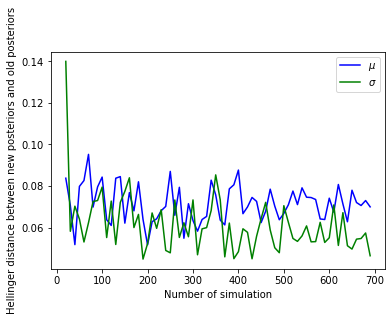

In [74]:
# Compute true posterior

# define the model
height = Gaussian([170, 10], name='height')

statistics_calculator = Identity(degree=2, cross=False)
distance_calculator = Euclidean(statistics_calculator)
backend = Backend()

sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

journal = sampler.sample([height_obs0], n_sample, n_samples_per_param, epsilon)
params= journal0.get_parameters()

hell_mu_conv = []
hell_sigma_conv = []

for par in param[1:]:
    hell_mu_conv.append(hell_Gaussian(par['mu'], params['mu'], 0.3, n=1000, plot = False))
    hell_sigma_conv.append(hell_Gaussian(par['sigma'], params['sigma'], 0.3, n=1000, plot = False))
    
    
fig3 = plt.figure()
plt.plot(np.arange(20, 700, 10), hell_mu_conv, 'b', label=r'$\mu$')
plt.plot(np.arange(20, 700, 10), hell_sigma_conv, 'g', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Number of simulation')
plt.ylabel('Hellinger distance between new posteriors and old posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell4')

print(params['mu'])
    

In [39]:
print(np.mean(np.squeeze(param[0]['mu'])))

distance_mean_mu = []
distance_mean_sigma = []

accepted_mean_mu = [np.mean(np.squeeze(param[0]['mu']))]
accepted_mean_sigma = [np.mean(np.squeeze(param[0]['sigma']))]

for par in param[1:]:
    accepted_mean_mu.append(np.mean(np.squeeze(par['mu'])))
    accepted_mean_sigma.append(np.mean(np.squeeze(par['sigma'])))
    
    distance_mean_mu.append(np.linalg.norm(accepted_mean_mu[-1] - accepted_mean_mu[-2]))
    distance_mean_sigma.append(np.linalg.norm(accepted_mean_sigma[-1] - accepted_mean_sigma[-2]))
    

173.38756273707878


50


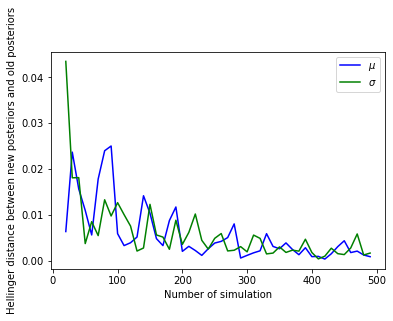

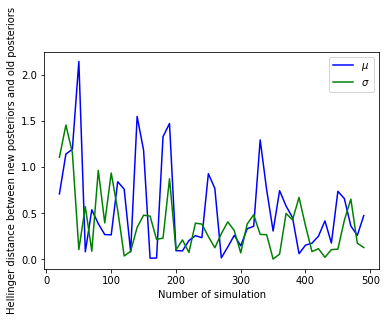

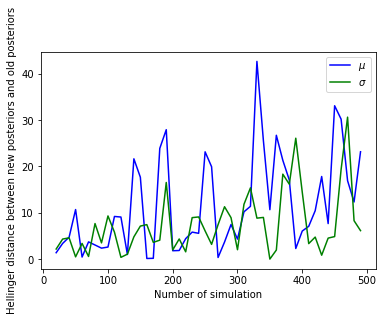

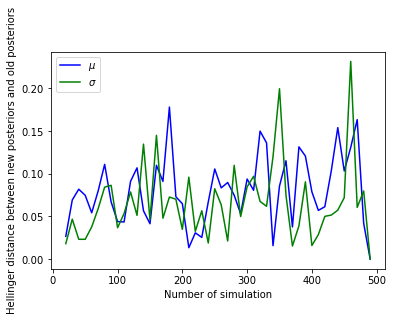

In [47]:
fig3 = plt.figure()
plt.plot(np.arange(20, 500, 10), hell_mu, 'b', label=r'$\mu$')
plt.plot(np.arange(20, 500, 10), hell_sigma, 'g', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Number of simulation')
plt.ylabel('Hellinger distance between new posteriors and old posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell4')

# error (true parameter and estimate parameter) decrease as number of data increase

print(len(height_obs0))


fig3 = plt.figure()
plt.plot(np.arange(20, 500, 10), distance_mean_mu, 'b', label=r'$\mu$')
plt.plot(np.arange(20, 500, 10), distance_mean_sigma, 'g', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Number of simulation')
plt.ylabel('Hellinger distance between new posteriors and old posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell4')

fig3 = plt.figure()
plt.plot(np.arange(20, 500, 10), distance_mean_mu*np.arange(20, 500, 10)/10, 'b', label=r'$\mu$')
plt.plot(np.arange(20, 500, 10), distance_mean_sigma*np.arange(20, 500, 10)/10, 'g', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Number of simulation')
plt.ylabel('Hellinger distance between new posteriors and old posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell4')

fig3 = plt.figure()
plt.plot(np.arange(20, 500, 10), hell_mu_conv*np.arange(20, 500, 10)/10, 'b', label=r'$\mu$')
plt.plot(np.arange(20, 500, 10), hell_sigma_conv*np.arange(20, 500, 10)/10, 'g', label=r'$\sigma$')
#print(hell_mu)
#print(hell_sigma)
plt.xlabel('Number of simulation')
plt.ylabel('Hellinger distance between new posteriors and old posteriors')
#plt.title('Histogram of IQ')
plt.legend()
plt.savefig('hell4')

In [31]:
'''fig4 = plt.figure()
for params in param:
    y0 = np.array(np.squeeze(params['mu']))
    
    eval_points = np.linspace(np.amin(y0), np.amax(y0), 1000)
    
    # Evaluate pdf of Gaussian kde
    p0 = Gaussian_kde(y0, 0.3, eval_points, True)
    #p1 = Gaussian_kde(y1, bandwidth, eval_points, False)
    '''

"fig4 = plt.figure()\nfor params in param:\n    y0 = np.array(np.squeeze(params['mu']))\n    \n    eval_points = np.linspace(np.amin(y0), np.amax(y0), 1000)\n    \n    # Evaluate pdf of Gaussian kde\n    p0 = Gaussian_kde(y0, 0.3, eval_points, True)\n    #p1 = Gaussian_kde(y1, bandwidth, eval_points, False)\n    "

In [ ]:
# 1 path corresponds to 1 data point
# what statistics give most information